In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib 
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from captum.attr import visualization as viz
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.loss_functions as lf
import mister_ed.utils.pytorch_utils as mister_ed_utils
from mister_ed.utils.pytorch_ssim import SSIM

### load the images

In [3]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

In [5]:
# image
img = Image.open("../sample_imagenet/sample_0.jpg")
img = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(img)))
img = img.unsqueeze(0).cuda()
# img = normalizer.forward(img).cuda()
# target image
target_img = Image.open("../sample_imagenet/sample_0_target.jpg")
target_img = torchvision.transforms.ToTensor()(
        torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(target_img)))
target_img = target_img.unsqueeze(0).cuda()
# target_img = normalizer.forward(target_img).cuda()

In [6]:

##
p_img = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}
###
for i in ["add", "add_recolor", "add_stadv", "add_stadv_recolor"]:
    for j in ["saliency", "smooth_grad", "uniform_grad", "softplus"]:
        if j == "softplus":
            for file in os.listdir("../examples/output_expl/"+i):
                if file.startswith("x_"):
                    p_img[i][j] = torch.load("../examples/output_expl/"+i+"/"+file)
        else:
            for file in os.listdir("../examples/output_expl_relu/"+i+"/"+j):
                if file.startswith("x_"):
                    p_img[i][j] = torch.load("../examples/output_expl_relu/"+i+"/"+j+"/"+file)

In [7]:
model = torchvision.models.vgg16(pretrained=True).to(device)
#softplus
softplus_model = convert_relu_to_softplus(model, beta=0.8)
softplus_model = softplus_model.eval()
####
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()
idx = model(normalizer.forward(img)).argmax()
print(idx)

tensor(17, device='cuda:0')


In [8]:
sigma = (torch.max(normalizer.forward(img)) - torch.min(normalizer.forward(img))).item() / 5
print("sigma: ", sigma)

sigma:  0.9447309494018554


In [9]:
# original explanations
expl_saliency = get_expl(model, normalizer.forward(img), "saliency", desired_index=idx).detach().cpu()
torch.cuda.empty_cache()
expl_smooth_grad = get_expl(model, normalizer.forward(img), "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()
expl_uniform_grad = get_expl(model, normalizer.forward(img), "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()
expl_softplus = get_expl(softplus_model, normalizer.forward(img), "saliency", desired_index=idx).detach().cpu()
torch.cuda.empty_cache()

#perturbed explanations
p_expl = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}

for i, att in enumerate(["add", "add_stadv", "add_recolor", "add_stadv_recolor"]):
    for j, method in enumerate(["saliency", "smooth_grad", "uniform_grad", "softplus"]):
        perturbed_img = p_img[att][method]
        if method == "smooth_grad":
            expl = get_expl(model, normalizer.forward(perturbed_img), "saliency", desired_index=idx, smooth=True, sigma=sigma)
        elif method == "softplus":
            expl = get_expl(softplus_model, normalizer.forward(perturbed_img), "saliency", desired_index=idx)
        else:
            expl = get_expl(model, normalizer.forward(perturbed_img), method, desired_index=idx, sigma=sigma)
        p_expl[att][method] = expl.detach().cpu()
        del expl
        torch.cuda.empty_cache()

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


### Visualize the results

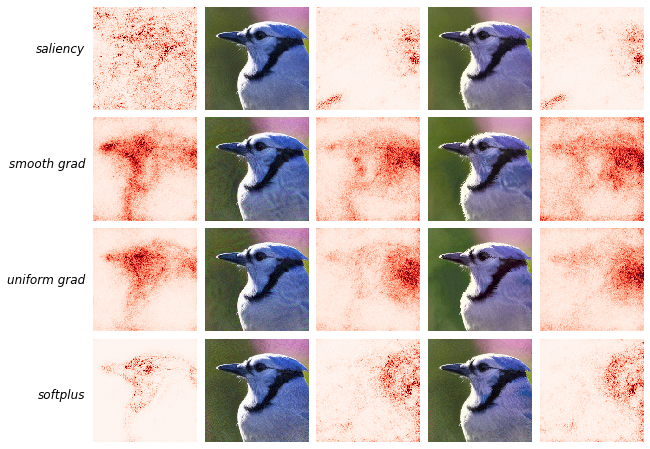

In [10]:


fig, ax = plt.subplots(4, 5, figsize=(10, 8))


viz.visualize_image_attr(np.transpose(expl_saliency.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_smooth_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_uniform_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_softplus.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[3, 0]), use_pyplot=False)

for i, att in enumerate(["add", "add_stadv_recolor"]):
    for j, method in enumerate(["saliency", "smooth_grad", "uniform_grad", "softplus"]):
        perturbed_img = p_img[att][method]
        ax[j, 2*i+1].imshow(torch_to_image(normalizer.forward(perturbed_img), data_mean, data_std))
        viz.visualize_image_attr(np.transpose(p_expl[att][method].squeeze().numpy(), (1,2,0)),
                             np.transpose(perturbed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[j, 2*i+2]), use_pyplot=False)
#################
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
# ax[0, 0].set_title("saliency", fontsize=12)
# ax[0, 1].set_title("smooth grad", fontsize=12)
# ax[0, 2].set_title("uniform grad", fontsize=12)
fig.text(0.12, 0.8, 'saliency', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.6, 'smooth grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.4, 'uniform grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.2, 'softplus', style = 'oblique', fontsize = 12, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'add+stadv+recolor', style = 'oblique', fontsize = 10, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("compare_attacks_viz.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

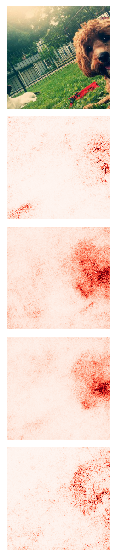

In [11]:
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
### target img label
target_idx = model(normalizer.forward(target_img)).argmax()
############
target_expl = get_expl(model, normalizer.forward(target_img), "saliency", desired_index=target_idx).detach().cpu()
target_expl_smooth_grad = get_expl(model, normalizer.forward(target_img), "saliency",
                                   smooth=True, sigma=sigma, desired_index=target_idx).detach().cpu()
target_expl_uniform_grad = get_expl(model, normalizer.forward(target_img), "uniform_grad",
                                   sigma=sigma, desired_index=target_idx).detach().cpu()
target_expl_softplus = get_expl(softplus_model, normalizer.forward(target_img), "saliency", desired_index=target_idx).detach().cpu()
torch.cuda.empty_cache()

ax[0].imshow(torch_to_image(normalizer.forward(target_img), data_mean, data_std))
viz.visualize_image_attr(np.transpose(target_expl.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(target_img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(target_expl_smooth_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(target_img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(target_expl_uniform_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(target_img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[3]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(target_expl_softplus.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(target_img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[4]), use_pyplot=False)

for i in range(len(ax)):
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("target_expl_map.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### Quantitative comparison

#### MSE

In [12]:
mse_to_target_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method in ["saliency", "smooth_grad", "uniform_grad", "softplus"]:
        if method == "softplus":
            with open("../examples/output_expl/"+att+"/output.log", "r") as f:
                lines = f.readlines()
        else:
            with open("../examples/output_expl_relu/"+att+"/"+method+"/output.log", "r") as f:
                lines = f.readlines()
        for l in lines[::-1]:
            if l.startswith("Final MSE"):
                mse_to_target_map[att][method] = float(l.strip().split(" ")[-1])
                break

In [13]:
mse_to_target_map

{'add': {'saliency': 2.2007222433284568e-10,
  'smooth_grad': 2.2297201585086412e-10,
  'uniform_grad': 2.315627550819599e-10,
  'softplus': 3.572964701881176e-10},
 'add_stadv': {'saliency': 2.4367244333411975e-10,
  'smooth_grad': 1.783623249096422e-10,
  'uniform_grad': 1.4730429376275112e-10,
  'softplus': 2.8208860247680434e-10},
 'add_recolor': {'saliency': 2.170077589846997e-10,
  'smooth_grad': 1.8823756442465367e-10,
  'uniform_grad': 2.0218619833922702e-10,
  'softplus': 4.5112866220442527e-10},
 'add_stadv_recolor': {'saliency': 2.3380367086822673e-10,
  'smooth_grad': 1.462035353894109e-10,
  'uniform_grad': 1.5822546051147413e-10,
  'softplus': 2.520677833128815e-10}}

#### LPIPS similarity for images 

In [14]:
import lpips

In [15]:
lpips_dist = lpips.LPIPS(net='vgg')
if torch.cuda.is_available():
    lpips_dist.cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/ubuntu/PerceptualSimilarity/lpips/weights/v0.1/vgg.pth


In [16]:
lpips_to_original_image = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0, "softplus": 0}}
for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method in ["saliency", "smooth_grad", "uniform_grad", "softplus"]:
        if method == "softplus":
            with open("../examples/output_expl/"+att+"/output.log", "r") as f:
                lines = f.readlines()
        else:
            with open("../examples/output_expl_relu/"+att+"/"+method+"/output.log", "r") as f:
                lines = f.readlines()
        lpips_to_original_image[att][method] = float(lines[-1].strip().split(" ")[-1])

In [17]:
lpips_to_original_image

{'add': {'saliency': 0.20438015460968018,
  'smooth_grad': 0.34494465589523315,
  'uniform_grad': 0.3662266731262207,
  'softplus': 0.3900764584541321},
 'add_stadv': {'saliency': 0.2318575233221054,
  'smooth_grad': 0.29220157861709595,
  'uniform_grad': 0.26852190494537354,
  'softplus': 0.36285507678985596},
 'add_recolor': {'saliency': 0.20953921973705292,
  'smooth_grad': 0.3108466565608978,
  'uniform_grad': 0.3168717324733734,
  'softplus': 0.3697608411312103},
 'add_stadv_recolor': {'saliency': 0.2557620108127594,
  'smooth_grad': 0.29974985122680664,
  'uniform_grad': 0.2830527722835541,
  'softplus': 0.3745371401309967}}

#### visual quantitative results

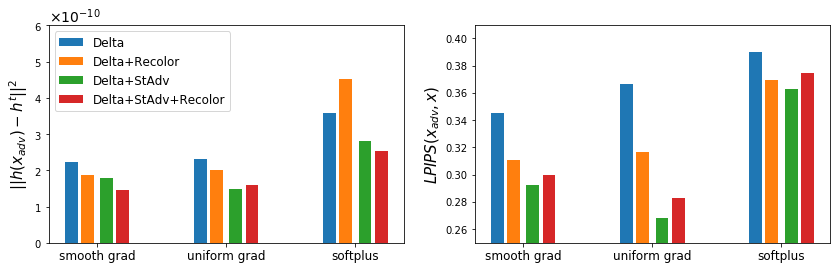

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2,3])
ax[0].bar(x_s - 0.2, 
           [mse_to_target_map["add"]["smooth_grad"], 
            mse_to_target_map["add"]["uniform_grad"],
            mse_to_target_map["add"]["softplus"]], width=0.1, label="Delta")

ax[0].bar(x_s - 0.075, 
           [mse_to_target_map["add_recolor"]["smooth_grad"],
            mse_to_target_map["add_recolor"]["uniform_grad"],
            mse_to_target_map["add_recolor"]["softplus"]], width=0.1, label="Delta+Recolor")

ax[0].bar(x_s + 0.075, 
           [mse_to_target_map["add_stadv"]["smooth_grad"],
            mse_to_target_map["add_stadv"]["uniform_grad"],
            mse_to_target_map["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv")

ax[0].bar(x_s + 0.2, 
           [mse_to_target_map["add_stadv_recolor"]["smooth_grad"],
            mse_to_target_map["add_stadv_recolor"]["uniform_grad"],
            mse_to_target_map["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor")

ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=6e-10)

ax[1].bar(x_s - 0.2, 
           [lpips_to_original_image["add"]["smooth_grad"],
            lpips_to_original_image["add"]["uniform_grad"],
            lpips_to_original_image["add"]["softplus"]], width=0.1, label="Delta")

ax[1].bar(x_s - 0.075, 
           [lpips_to_original_image["add_recolor"]["smooth_grad"],
            lpips_to_original_image["add_recolor"]["uniform_grad"],
            lpips_to_original_image["add_recolor"]["softplus"]], width=0.1, label="Delta+Recolor")

ax[1].bar(x_s + 0.075, 
           [lpips_to_original_image["add_stadv"]["smooth_grad"],
            lpips_to_original_image["add_stadv"]["uniform_grad"],
            lpips_to_original_image["add_stadv"]["softplus"]], width=0.1, label="Delta+StAdv")

ax[1].bar(x_s + 0.2, 
           [lpips_to_original_image["add_stadv_recolor"]["smooth_grad"],
            lpips_to_original_image["add_stadv_recolor"]["uniform_grad"],
            lpips_to_original_image["add_stadv_recolor"]["softplus"]], width=0.1, label="Delta+StAdv+Recolor")

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
# ax[1].legend(fontsize=12)
ax[1].set_ylim(bottom=0.25)
ax[1].set_ylabel(r"$LPIPS(x_{adv}, x)$", fontsize=15)
plt.savefig("compare_attacks_mse.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### SSIM

In [12]:
ssim_similarity = SSIM()

In [13]:
ssim_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        ssim_to_original_map[att][method] = ssim_similarity.forward(org_map, p_expl[att][method])

In [14]:
ssim_to_original_map

{'add': {'saliency': tensor(0.4872),
  'smooth_grad': tensor(0.9801),
  'uniform_grad': tensor(0.9248)},
 'add_stadv': {'saliency': tensor(0.5004),
  'smooth_grad': tensor(0.9632),
  'uniform_grad': tensor(0.9183)},
 'add_recolor': {'saliency': tensor(0.4857),
  'smooth_grad': tensor(0.9748),
  'uniform_grad': tensor(0.9242)},
 'add_stadv_recolor': {'saliency': tensor(0.4955),
  'smooth_grad': tensor(0.9670),
  'uniform_grad': tensor(0.9122)}}

#### spearman rank-order correlation

In [15]:
from scipy.stats import spearmanr as spr
import scipy.spatial as spatial

In [16]:
spr_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        spr_to_original_map[att][method] = spr(org_map.flatten(), p_expl[att][method].flatten())[0]

In [17]:
spr_to_original_map

{'add': {'saliency': 0.13812864846985415,
  'smooth_grad': 0.6853185343601743,
  'uniform_grad': 0.6116536545388386},
 'add_stadv': {'saliency': 0.13435543310168865,
  'smooth_grad': 0.5847530882905764,
  'uniform_grad': 0.618118020844993},
 'add_recolor': {'saliency': 0.13082831144309479,
  'smooth_grad': 0.6399418571554515,
  'uniform_grad': 0.6441179753794173},
 'add_stadv_recolor': {'saliency': 0.13146664326413446,
  'smooth_grad': 0.6049617633483584,
  'uniform_grad': 0.595193332003895}}

#### cosine distance

In [18]:
cosd_to_original_map = {"add": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}, 
         "add_stadv": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0},
         "add_stadv_recolor": {"saliency": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add", "add_stadv", "add_recolor", "add_stadv_recolor"]:
    for method, org_map in zip(["saliency", "smooth_grad", "uniform_grad"], 
                               [expl_saliency, expl_smooth_grad, expl_uniform_grad]):
        cosd_to_original_map[att][method] = float(spatial.distance.cosine(org_map.flatten(), 
                                                                          p_expl[att][method].flatten()))

In [19]:
cosd_to_original_map

{'add': {'saliency': 0.5418198704719543,
  'smooth_grad': 0.16042709350585938,
  'uniform_grad': 0.21913832426071167},
 'add_stadv': {'saliency': 0.5500043332576752,
  'smooth_grad': 0.2441752552986145,
  'uniform_grad': 0.24832648038864136},
 'add_recolor': {'saliency': 0.5490026473999023,
  'smooth_grad': 0.18255573511123657,
  'uniform_grad': 0.23156660795211792},
 'add_stadv_recolor': {'saliency': 0.5533339083194733,
  'smooth_grad': 0.22555547952651978,
  'uniform_grad': 0.272874116897583}}

### CIEDE

In [24]:
##
p_img_ciede = {"add": {"softplus": 0, "smooth_grad": 0, "uniform_grad": 0}}
###
for i in ["add"]:
    for j in ["smooth_grad", "uniform_grad", "softplus"]:
        if j == "softplus":
            for file in os.listdir("../examples/output_expl/ciede/"+i):
                if file.startswith("x_"):
                    p_img_ciede[i][j] = torch.load("../examples/output_expl/ciede/"+i+"/"+file)
        else:
            for file in os.listdir("../examples/output_expl_relu/ciede/"+i+"/"+j):
                if file.startswith("x_"):
                    p_img_ciede[i][j] = torch.load("../examples/output_expl_relu/"+i+"/"+j+"/"+file)

In [26]:

#perturbed explanations
p_expl_ciede = {"add": {"softplus": 0, "smooth_grad": 0, "uniform_grad": 0}}
for i, att in enumerate(["add"]):
    for j, method in enumerate(["smooth_grad", "uniform_grad", "softplus"]):
        perturbed_img = p_img_ciede[att][method]
        if method == "smooth_grad":
            expl = get_expl(model, normalizer.forward(perturbed_img), "saliency", desired_index=idx, smooth=True, sigma=sigma)
        elif method == "softplus":
            expl = get_expl(softplus_model, normalizer.forward(perturbed_img), "saliency", desired_index=idx)
        else:
            expl = get_expl(model, normalizer.forward(perturbed_img), method, desired_index=idx, sigma=sigma)
        p_expl_ciede[att][method] = expl.detach().cpu()
        del expl
        torch.cuda.empty_cache()

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


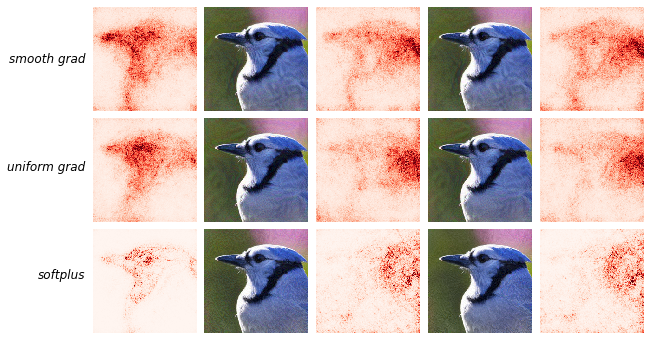

In [36]:


fig, ax = plt.subplots(3, 5, figsize=(10, 6))

viz.visualize_image_attr(np.transpose(expl_smooth_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_uniform_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_softplus.squeeze().numpy(), (1,2,0)),
                             np.transpose(normalizer.forward(img).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)


for i, att in enumerate(["add", "add_ciede"]):
    for j, method in enumerate(["smooth_grad", "uniform_grad", "softplus"]):
        if att == "add_ciede":
            perturbed_img = p_img_ciede["add"][method]
            ax[j, 2*i+1].imshow(torch_to_image(normalizer.forward(perturbed_img), data_mean, data_std))
            viz.visualize_image_attr(np.transpose(p_expl_ciede["add"][method].squeeze().numpy(), (1,2,0)),
                             np.transpose(perturbed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[j, 2*i+2]), use_pyplot=False)
        else:
            perturbed_img = p_img["add"][method]
            ax[j, 2*i+1].imshow(torch_to_image(normalizer.forward(perturbed_img), data_mean, data_std))
            viz.visualize_image_attr(np.transpose(p_expl["add"][method].squeeze().numpy(), (1,2,0)),
                             np.transpose(perturbed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[j, 2*i+2]), use_pyplot=False)
        
#################
for i in range(3):
    for j in range(5):
        ax[i,j].axis('off')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
# ax[0, 0].set_title("saliency", fontsize=12)
# ax[0, 1].set_title("smooth grad", fontsize=12)
# ax[0, 2].set_title("uniform grad", fontsize=12)
fig.text(0.12, 0.75, 'smooth grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.5, 'uniform grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.25, 'softplus', style = 'oblique', fontsize = 12, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.008, hspace=0.07)
plt.savefig("compare_attacks_viz_ciede.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### MSE

In [31]:
mse_to_target_map_ciede = {"add": {"softplus": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        if method == "softplus":
            with open("../examples/output_expl/ciede/"+att+"/output.log", "r") as f:
                lines = f.readlines()
        else:
            with open("../examples/output_expl_relu/ciede/"+att+"/"+method+"/output.log", "r") as f:
                lines = f.readlines()
        for l in lines[::-1]:
            if l.startswith("Final MSE"):
                mse_to_target_map_ciede[att][method] = float(l.strip().split(" ")[-1])
                break

In [32]:
mse_to_target_map_ciede

{'add': {'softplus': 3.386285696294067e-10,
  'smooth_grad': 2.3532656379110506e-10,
  'uniform_grad': 1.626117573927388e-10}}

#### LPIPS

In [33]:
lpips_to_original_image_ciede = {"add": {"softplus": 0, "smooth_grad": 0, "uniform_grad": 0}}

for att in ["add"]:
    for method in ["smooth_grad", "uniform_grad", "softplus"]:
        if method == "softplus":
            with open("../examples/output_expl/ciede/"+att+"/output.log", "r") as f:
                lines = f.readlines()
        else:
            with open("../examples/output_expl_relu/ciede/"+att+"/"+method+"/output.log", "r") as f:
                lines = f.readlines()
        lpips_to_original_image_ciede[att][method] = float(lines[-1].strip().split(" ")[-1])
        

#### viz

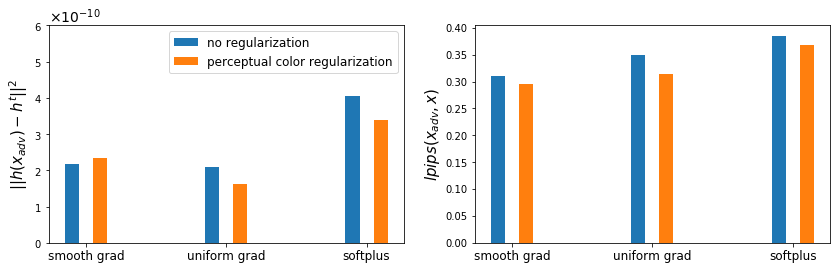

In [35]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))

x_s = np.array([1,2,3])
ax[0].bar(x_s - 0.1, 
           [mse_to_target_map["add"]["smooth_grad"], mse_to_target_map["add"]["uniform_grad"], 
            mse_to_target_map["add"]["softplus"]], width=0.1, label="no regularization")

ax[0].bar(x_s + 0.1, 
           [mse_to_target_map_ciede["add"]["smooth_grad"], mse_to_target_map_ciede["add"]["uniform_grad"],
            mse_to_target_map_ciede["add"]["softplus"]], width=0.1, label="perceptual color regularization")


ax[0].set_xticks(x_s)
ax[0].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
ax[0].legend(fontsize=12)
ax[0].set_ylabel(r"$||h(x_{adv}) - h^t||^2$", fontsize=15)
ax[0].ticklabel_format(style='sci', axis='y',scilimits=(0,0), useMathText=True)
ax[0].yaxis.get_offset_text().set_fontsize(14)
ax[0].set_ylim(top=6e-10)

ax[1].bar(x_s - 0.1, 
           [lpips_to_original_image["add"]["smooth_grad"], lpips_to_original_image["add"]["uniform_grad"],
           lpips_to_original_image["add"]["softplus"]], width=0.1, label="no regularization")

ax[1].bar(x_s + 0.1, 
           [lpips_to_original_image_ciede["add"]["smooth_grad"], lpips_to_original_image_ciede["add"]["uniform_grad"],
           lpips_to_original_image_ciede["add"]["softplus"]], width=0.1, label="perceptual color regularization")

ax[1].set_xticks(x_s)
ax[1].set_xticklabels(["smooth grad", "uniform grad", "softplus"], fontsize=12)
# ax[1].legend(fontsize=12)
ax[1].set_ylabel(r"$lpips(x_{adv}, x)$", fontsize=15)
plt.savefig("compare_attacks_mse_ciede.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);